In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import plotly.express as pl
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import shgo
from scipy.optimize import dual_annealing
from scipy.optimize import brute

In [54]:
def profit(a, b, mc, n, fc, r, b0, b1):
    return ((a - mc) / (n + 1))**2 / (b * r) * (1 + r) - (1+r)*fc/(1+r-b1) - b0/(1-b1)*((1+r)/r-(1+r)/(1+r-b1))

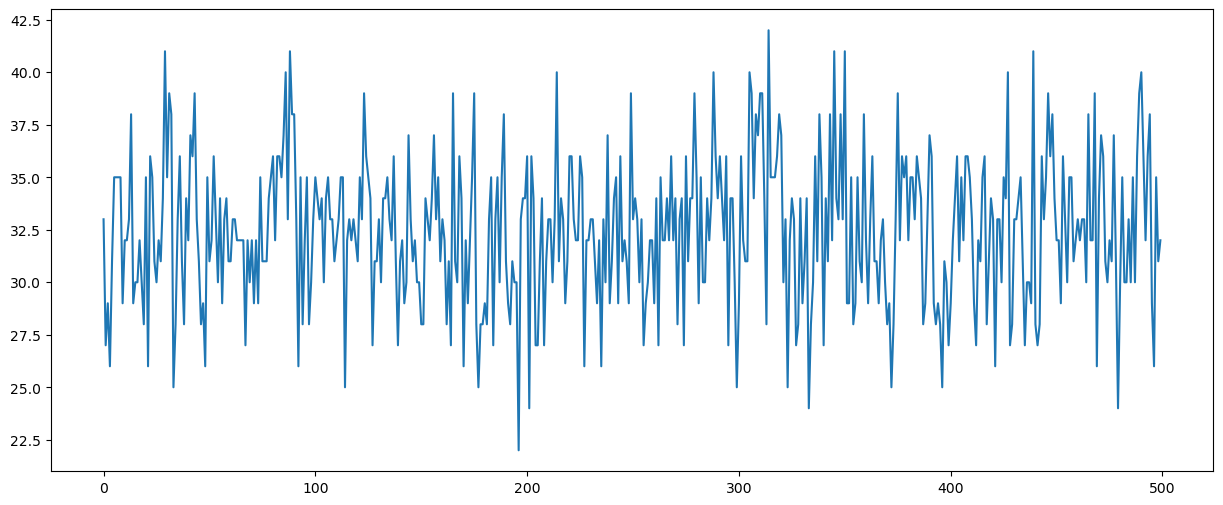

In [65]:
BETA_0 = 0.01
BETA_1 = 0.9
MC = 0.1
A = 5
B = 0.1
N_0 = 10
TIMES = 500
R = 0.07

# F_intial = np.array([BETA_0 / (1 - BETA_1)] * N_0)
F_intial = np.array([0] * N_0)
F_dct = dict(zip(np.arange(0, N_0), F_intial))
N_history = []
L_history = []
N_calc = []
F_history = []
max_n = N_0 - 1
std = 0.1

mean_enters = 20

for i in range(TIMES):
    # Enter step
    for j in range(np.random.poisson(mean_enters)):
        # F_dct[max_n+1] = BETA_0 / (1 - BETA_1)
        F_dct[max_n+1] = 0
        max_n = max_n+1
    
    # Recalculation step
    for j in F_dct.keys():
        F_dct[j] = BETA_0 + BETA_1 * F_dct[j] + np.random.normal(0, std)
        
    # Exit step
    bad_firms = []
    n = len(F_dct.keys())
    
    for j in F_dct.keys():
        pi = profit(A, B, MC, n, F_dct[j], R, BETA_0, BETA_1)
        if np.random.gumbel(0, 1) > pi + np.random.gumbel(0, 1):
            bad_firms.append(j)

    F_history.append(F_dct.copy())
    for j in bad_firms: 
        del F_dct[j]
    # Saving
    L_history.append(len(bad_firms))
    N_history.append(len(F_dct.keys()))
    N_calc.append(n)
    
    
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(N_history)), N_history)
plt.show() 

In [66]:
X = pd.DataFrame(F_history)

X["time"] = X.index
X["N"] = N_history
X["L"] = L_history
X["N_calc"] = N_calc

X = pd.melt(X, 
        id_vars=["N", "L", "N_calc", "time"],
        value_vars=X.columns[:-4]).dropna()

X["n"] = 1/(X["N_calc"]+1)**2
X = sm.add_constant(X)

indicators = []

for i in range(len(X["variable"])):
    
    if i==len(X["variable"])-1:
        indicators.append(0)
        break
        
    if X["variable"].iloc[i]==X["variable"].iloc[i+1]:
        indicators.append(1)
    else:
        indicators.append(0)
        
X["Y"] = indicators

X["FC"] = X.groupby('variable')["value"].shift()
X = X.dropna()

In [67]:
X

,const,N,L,N_calc,time,variable,value,n,Y,FC
1,1.0,27,31,58,1,0,-0.113571,0.000287,1,0.044471
2,1.0,29,16,45,2,0,-0.333216,0.000473,1,-0.113571
3,1.0,26,22,48,3,0,-0.183438,0.000416,1,-0.333216
4,1.0,31,13,44,4,0,-0.404924,0.000494,1,-0.183438
5,1.0,35,22,57,5,0,-0.374996,0.000297,0,-0.404924
...,...,...,...,...,...,...,...,...,...,...
4971999,1.0,32,19,51,499,9943,0.191224,0.000370,0,0.064844
4972999,1.0,32,19,51,499,9945,-0.252694,0.000370,0,-0.140122
4973999,1.0,32,19,51,499,9947,-0.165014,0.000370,0,-0.075528
4974999,1.0,32,19,51,499,9949,0.021426,0.000370,0,0.033111


In [68]:
FC_t = X['value']
FC_t_lag = X['FC']

# Добавляем константу
X_fc = sm.add_constant(FC_t_lag)

# Регрессия
model_ar = sm.OLS(FC_t, X_fc).fit()
X["FC_pred"] = model_ar.predict()
a0, a1 = model_ar.params
a0, a1

# Подготовка данных для оценки
n = X['n'].values
# fc_lag = X['value'].values
fc_lag = X["FC_pred"].values
stay = X['Y'].values

X["const"] = 1

logit_mod = sm.Logit(stay, X[["n", "value", "const"]])
# logit_res = logit_mod.fit_constrained("value = 1")
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.554391
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                16182
Model:                          Logit   Df Residuals:                    16179
Method:                           MLE   Df Model:                            2
Date:                Sat, 22 Feb 2025   Pseudo R-squ.:                  0.1423
Time:                        01:32:00   Log-Likelihood:                -8971.2
converged:                       True   LL-Null:                       -10459.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
n           3602.6926    233.803     15.409      0.000    3144.446    4060.939
value         -6.2799      0.137    -45.806      0.000      -6.549      -6.011
const         -0.8673      0.085    -10.219      0.000      -1.034      -0.701
==============================================================================
"""

In [69]:
(A - MC)**2 / (B * R) * (1 + R), (1+R)/(1+R-BETA_1), BETA_0/(1-BETA_1)*((1+R)/R-(1+R)/(1+R-BETA_1))

(3670.100000000001, 6.2941176470588225, 0.8991596638655464)

<AxesSubplot:>

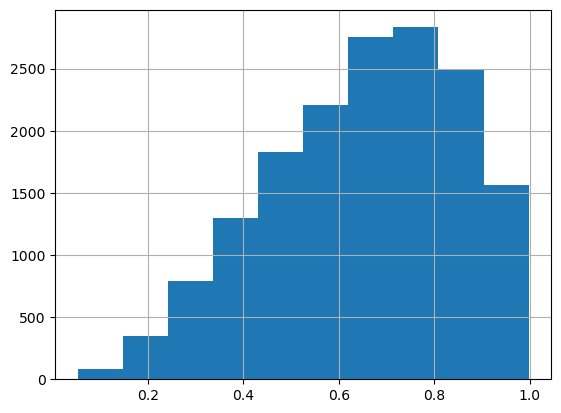

In [71]:
logit_res.predict(X[["n", "value", "const"]]).hist()